In [1]:
from ouster import client
from ouster import pcap
from ouster.sdk import viz

# import open3d as o3d
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches


import numpy as np

from os.path import join

from PIL import Image

<h1> Reading Files</h1>

In [2]:
metadata_path = join('.', 'data','Sample_Data','meta.json')
pcap_path = join('.', 'data','Sample_Data','data.pcap')

In [3]:
with open(metadata_path, 'r') as f:
    metadata = client.SensorInfo(f.read())

In [4]:
source = pcap.Pcap(pcap_path, metadata)

In [5]:
xyzlut = client.XYZLut(metadata)

In [6]:
scans = iter(client.Scans(source))

In [7]:
scan = next(scans)

In [8]:
ranges = scan.field(client.ChanField.RANGE)

In [9]:
signal = scan.field(client.ChanField.SIGNAL)

In [12]:
ranges.shape

(128, 1024)

<h1> Destaggering and inverse destaggering</h1>

<h3> Let's first see a staggered range image </h3> 

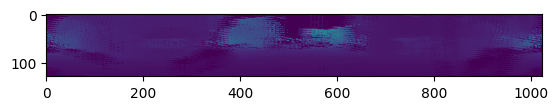

In [13]:
imgplot = plt.imshow(ranges)
plt.show()

<h3>Let's see a Destaggered range image </h3>

In [14]:
destaggered_ranges = client.destagger(metadata,ranges)
destaggered_ranges.shape

(128, 1024)

In [15]:
x1 = 260
y1 = 70
h = 50
w = 140

x2 = x1 + w 
y2 = y1 + h

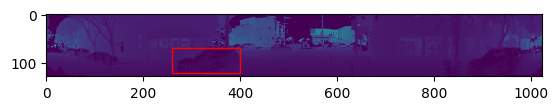

In [16]:
fig,ax = plt.subplots()
rect = patches.Rectangle((x1,y1),w,h,linewidth=1,edgecolor='r',facecolor='none')

ax.add_patch(rect)

ax.imshow(destaggered_ranges)

plt.show()

<h3>Let's see a staggered range image obtained by inverse staggering</h3>

In [17]:
de_destaggered_ranges = client.destagger(metadata,destaggered_ranges,inverse=True)
de_destaggered_ranges.shape

(128, 1024)

They both are equal as expected

In [18]:
(ranges==de_destaggered_ranges).all()

True

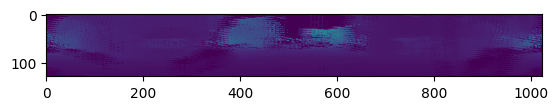

In [19]:
imgplot = plt.imshow(de_destaggered_ranges)
plt.show()

<h1>Destaggering for xyz points</h1>

In [72]:
# xyz_sig = xyzlut(signal)

In [68]:
xyz = xyzlut(ranges)

In [24]:
xyz_sig.shape

NameError: name 'xyz_sig' is not defined

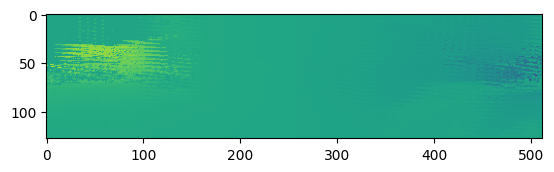

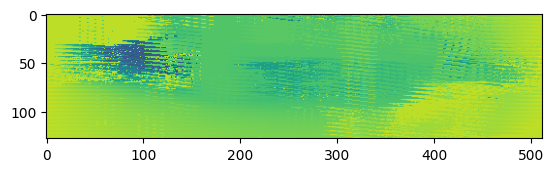

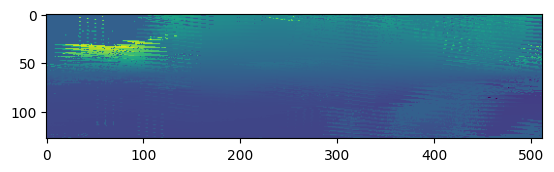

In [69]:
xyz.shape

imgplot = plt.imshow(xyz[:,512:,0])
plt.show()

imgplot = plt.imshow(xyz[:,512:,1])
plt.show()

imgplot = plt.imshow(xyz[:,512:,2])
plt.show()

Not sure why but the xyz points from signal is different from xyz points from range.

In [76]:
(xyz == xyz_sig).all()

False

<h3> Let's first see a staggered pcd </h3> 

In [70]:
def get_axis():
    x_ = np.array([1, 0, 0]).reshape((-1, 1))
    y_ = np.array([0, 1, 0]).reshape((-1, 1))
    z_ = np.array([0, 0, 1]).reshape((-1, 1))

    axis_n = 100
    line = np.linspace(0, 1, axis_n).reshape((1, -1))

    # basis vector to point cloud
    axis_points = np.hstack((x_ @ line, y_ @ line, z_ @ line)).transpose()

    # colors for basis vectors
    axis_color_mask = np.vstack((np.full(
        (axis_n, 4), [1, 0.1, 0.1, 1]), np.full((axis_n, 4), [0.1, 1, 0.1, 1]),
                                np.full((axis_n, 4), [0.1, 0.1, 1, 1])))

    cloud_axis = viz.Cloud(axis_points.shape[0])

    cloud_axis.set_xyz(axis_points)
    cloud_axis.set_key(np.full(axis_points.shape[0], 0.5))
    cloud_axis.set_mask(axis_color_mask)
    cloud_axis.set_point_size(3)
    
    return cloud_axis

In [71]:
point_viz = viz.PointViz("Testing")
viz.add_default_controls(point_viz)
axis = get_axis()
point_viz.add(axis)            

In [72]:
cloud_xyz = viz.Cloud(xyz.shape[0] * xyz.shape[1])
cloud_xyz.set_xyz(np.reshape(xyz, (-1, 3)))
# cloud_xyz.set_key(ranges.ravel()) #This is for coloring not required

point_viz.add(cloud_xyz)

In [73]:
point_viz.update()
point_viz.run()

<h2>Display bbox in 3d</h2>

In [43]:
xyz.shape

(128, 1024, 3)

In [74]:
# car_points = xyz[y1:y2,x1:x2]
car_points = xyz[:,512:]
car_points.shape

(128, 512, 3)

In [75]:
n = car_points.reshape((-1,3))
n.shape

(65536, 3)

In [61]:
# [x,y,z] = [c.flatten() for c in np.dsplit(car_points, 3)]
# print(x.shape,y.shape,z.shape)
# n = np.stack((x,y,z),axis=-1)
# n.shape

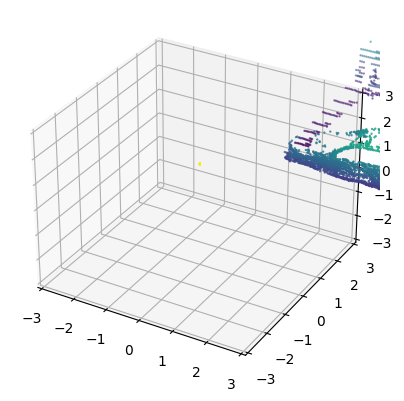

In [62]:
plt.figure()
ax = plt.axes(projection='3d')
r = 3
ax.set_xlim3d([-r, r])
ax.set_ylim3d([-r, r])
ax.set_zlim3d([-r, r])

z[z==0] = 1

ax.scatter(x, y, z, c=z / max(z),s=0.5)

plt.show()

In [76]:
point_viz = viz.PointViz("Testing")
viz.add_default_controls(point_viz)
axis = get_axis()
point_viz.add(axis)            

In [77]:
cloud_xyz = viz.Cloud(n.shape[0])
cloud_xyz.set_xyz(n)
# cloud_xyz.set_key(ranges[y1:y2,x1:x2].ravel()/np.max(ranges[y1:y2,x1:x2])) #This is for coloring not required
# cloud_xyz.set_key(ranges[:,1:].ravel()) #This is for coloring not required

point_viz.add(cloud_xyz)

In [78]:
point_viz.update()
point_viz.run()

<h3>Now let's see a destaggered pcd </h3>

In [64]:
destaggered_xyz = client.destagger(metadata,xyz)

In [65]:
destaggered_xyz.shape

(128, 1024, 3)

In [66]:
(destaggered_xyz == xyz).all()

False

In [67]:
point_viz = viz.PointViz("Testing")
viz.add_default_controls(point_viz)
axis = get_axis()
point_viz.add(axis)            

In [68]:
cloud_destaggered_xyz = viz.Cloud(destaggered_xyz.shape[0] * destaggered_xyz.shape[1])
cloud_destaggered_xyz.set_xyz(np.reshape(destaggered_xyz, (-1, 3)))

point_viz.add(cloud_destaggered_xyz)

In [69]:
point_viz.update()
point_viz.run()

<h3>Let's see a staggered pcd obtained by inverse staggering</h3>

In [70]:
de_destaggered_xyz = client.destagger(metadata,destaggered_xyz,inverse=True)

In [71]:
hash(xyz.data.tobytes())

3263830359212093309

In [72]:
hash(de_destaggered_xyz.data.tobytes())

3263830359212093309

In [84]:
np.array_equal(de_destaggered_xyz,xyz)

True

In [74]:
(de_destaggered_xyz.reshape((-1,3)) == xyz.reshape((-1,3))).all()

True

In [75]:
point_viz = viz.PointViz("Testing")
viz.add_default_controls(point_viz)
axis = get_axis()
point_viz.add(axis)

In [76]:
cloud_xyz = viz.Cloud(xyz.shape[0] * xyz.shape[1])
cloud_xyz.set_xyz(np.reshape(xyz, (-1, 3)))

point_viz.add(cloud_xyz)

In [77]:
point_viz.update()
point_viz.run()

In [78]:
point_viz = viz.PointViz("Testing")
viz.add_default_controls(point_viz)
axis = get_axis()
point_viz.add(axis)            

In [79]:
cloud_de_destaggered_xyz = viz.Cloud(de_destaggered_xyz.shape[0] * de_destaggered_xyz.shape[1])
cloud_de_destaggered_xyz.set_xyz(np.reshape(de_destaggered_xyz, (-1, 3)))

point_viz.add(cloud_de_destaggered_xyz)

In [80]:
point_viz.update()
point_viz.run()

<h4>This is so confusing de_destaggered_xyz and xyz are the same</h4>

If you see the above cells, I checking if they are same by value by value comparision and hash comparision.
They are the same but somehow the 3d plot looks different. I'm not sure how the ouster viz differentiates between these 
two. I thought maybe it's using some metadata of these objects but they are vanilla numpy arrays.

I also tested if somehow these arrays are sharing memory. The arrays returned by the client.destagger does seem to share memory with some other array but they are not the array I'm using (probably some internal array.)


So the arrays are the same but the visualizer is displaying it differently?

https://static.ouster.dev/sdk-docs/python/api/viz.html#cloud-for-3d-point-cloud

There's one thing I don't understand in the point cloud visualization from ouster. This likely because of that.
They talk about a poses for each point and I am not sure what they are referring to. Maybe the visualzier is doing some internal computation that ends up being differnt for these two array?

I also found some metadata between these two arrays that are different (refer to the cells below) and I am currently figuring out how to resolve this.

In [81]:
print(xyz.strides)
xyz.flags

(8192, 8, 1048576)


  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [82]:
print(de_destaggered_xyz.strides)
de_destaggered_xyz.flags

(24576, 24, 8)


  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [ ]:
strided_de_destaggered_xyz=np.lib.stride_tricks.as_strided(de_destaggered_xyz,strides=xyz.strides,shape=de_destaggered_xyz.shape)

In [ ]:
#vis = o3d.visualization.Visualizer()
# vis.create_window()

# opt = vis.get_render_option()
# opt.show_coordinate_frame = True
# axis = o3d.geometry.